## make sure you have start the triton server successfully in ANOTHER terminal 

In [49]:
%%html
    <tr>
    <td> <img src="./pics/start_triton_server_successfully.JPG" alt="image" style="width: 1200px;"/> </td>
    </tr>

""


In [1]:
import argparse
import numpy as np
import os
import json
from builtins import range
import tensorrtserver.api.model_config_pb2 as model_config
from tensorrtserver.api import *
import os
#os.makedirs('./model_repo/custom_plan/1/',exist_ok=True)

## copy entire directory from local model_repository/custom_plan/ to Triton model serving directory ./empty_dir/custom_plan/

In [4]:
!cp -R ./model_repository/custom_plan/ ./empty_dir/custom_plan/

## check the server is live and function properly

In [5]:
url = 'localhost:8000'
protocol = ProtocolType.HTTP

health_ctx = ServerHealthContext(url, protocol, verbose=True)
print("Live: {}".format(health_ctx.is_live()))
print("Ready: {}".format(health_ctx.is_ready()))

Live: True
Ready: True


## check the model.plan is parsed correctly 

In [6]:
model_name = "custom_plan"
# Create a status context and get server status
status_ctx = ServerStatusContext(url, protocol, model_name, verbose=True)
print("Status for model {}".format(model_name))
print(status_ctx.get_server_status())

Status for model custom_plan
id: "inference:0"
version: "1.14.0"
uptime_ns: 451996992140
model_status {
  key: "custom_plan"
  value {
    config {
      name: "custom_plan"
      platform: "tensorrt_plan"
      version_policy {
        latest {
          num_versions: 1
        }
      }
      max_batch_size: 1
      input {
        name: "hand_drawing:0"
        data_type: TYPE_FP32
        format: FORMAT_NHWC
        dims: 224
        dims: 224
        dims: 3
        reshape {
          shape: 1
          shape: 224
          shape: 224
          shape: 3
        }
      }
      output {
        name: "Identity:0"
        data_type: TYPE_FP32
        dims: 1
        label_filename: "labels.txt"
        reshape {
          shape: 1
          shape: 1
        }
      }
      instance_group {
        name: "custom_plan_0"
        count: 2
        gpus: 0
        kind: KIND_GPU
      }
      default_model_filename: "model.plan"
      dynamic_batching {
        preferred_batch_size: 1
 

In [7]:
ctx = ServerStatusContext(url, protocol, model_name, True)
server_status = ctx.get_server_status()

if model_name not in server_status.model_status:
    raise Exception("unable to get status for '" + model_name + "'")

status = server_status.model_status[model_name]
config = status.config

In [8]:
def parse_model(url, protocol, model_name, batch_size, verbose=False):
    """
    Check the configuration of a model to make sure it meets the
    requirements
    """
    ctx = ServerStatusContext(url, protocol, model_name, verbose)
    server_status = ctx.get_server_status()

    if model_name not in server_status.model_status:
        raise Exception("unable to get status for '" + model_name + "'")

    status = server_status.model_status[model_name]
    config = status.config

    if len(config.input) != 1:
        raise Exception("expecting 1 input, got {}".format(len(config.input)))
    if len(config.output) != 1:
        raise Exception("expecting 1 output, got {}".format(len(config.output)))

    input = config.input[0]
    output = config.output[0]
    
    # Model specifying maximum batch size of 0 indicates that batching
    # is not supported and so the input tensors do not expect an "N"
    # dimension (and 'batch_size' should be 1 so that only a single
    # image instance is inferred at a time).
    max_batch_size = config.max_batch_size
    if max_batch_size == 0:
        if batch_size != 1:
            raise Exception("batching not supported for model '" + model_name + "'")
    else: # max_batch_size > 0
        if batch_size > max_batch_size:
            raise Exception("expecting batch size <= {} for model {}".format(max_batch_size, model_name))

#     Model input must have 3 dims, either CHW or HWC
    if len(input.dims) != 3:
        raise Exception(
            "expecting input to have 3 dimensions, model '{}' input has {}".format(
                model_name, len(input.dims)))

    if input.format == model_config.ModelInput.FORMAT_NHWC:
        h = input.dims[0]
        w = input.dims[1]
        c = input.dims[2]
    else:
        c = input.dims[0]
        h = input.dims[1]
        w = input.dims[2]

    return (input.name, output.name, c, h, w, input.format, input.data_type)

In [9]:
model_version = -1
batch_size = 1

input_name, output_name, c, h, w, format, dtype = parse_model(url, protocol, model_name, batch_size, verbose=True)
input_name, output_name, c,h, w

('hand_drawing:0', 'Identity:0', 3, 224, 224)

## verify the triton server load the custom_plan model successfully 

In [48]:
%%html
    <tr>
    <td> <img src="./pics/custom_plan_load_successfully.JPG" alt="image" style="width: 1200px;"/> </td>
    </tr>

""


## get data for reference 

In [10]:
import numpy as np
import os
import pickle
from PIL import Image

# define the path to the training and testing directories
dataset_wave='./data/spiral/'
trainingPath = dataset_wave+ "training/"
testingPath = dataset_wave+"testing/"
import numpy as np
def get_data(data_path):
    X=[]
    Y=[]
    # loop through each image path and fetch the features, then write to index per row 
    #for ext in ('*.gif', '*.png', '*.jpg','*.jpeg'):
    label_paths=['healthy','parkinson']
    for label_path in label_paths:
        img_dir=data_path+label_path
        img_files=os.listdir(img_dir)
        if label_path=='healthy':
            ls=[ Y.append(0) for i in range(len(img_files))]
        else:
            ls=[ Y.append(1) for i in range(len(img_files))]
        for im_name in img_files:
            img = Image.open(img_dir+'/'+im_name)
            img = img.convert('RGB')
            img = img.resize((224, 224), Image.BILINEAR)
            img = np.array(img)

            img=img/255
            X.append(img)
                
    Y=np.array(Y)
    X=np.array(X)
    return X, Y
Xtrain, Ytrain=get_data(trainingPath)
Xtest,Ytest=get_data(testingPath )

Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((72, 224, 224, 3), (72,), (42, 224, 224, 3), (42,))

In [46]:
import random
rn=random.randint(0,len(Xtest)-1)

print(rn), Xtest[rn].shape, Ytest[rn], Ytest[33]

1


(None, (224, 224, 3), 0, 1)

In [47]:
def find_parkinson_idx(Y):
    flag=0
    while flag==0:
        rn=random.randint(0,len(Y)-1)
        if Ytest[rn]==1:
            flag=1
            return rn

rn=1
rn2=33


In [48]:
def triton_inferer(ctx, input_name, output_name, batch):
    #batch = [batch[i].cpu().numpy().astype(np.float32) for i in range(0,batch.shape[0]) ]
    batch = [batch[i].astype(np.float32) for i in range(0,batch.shape[0]) ]
    input_dict = { input_name : batch }
    output_dict = { output_name : (InferContext.ResultFormat.RAW)}
    results = ctx.run(
        inputs=input_dict, 
        outputs=output_dict, 
        batch_size=len(batch)
    )
    return results[output_name]

def process_prob2pred(model_output):
    #modify from process_results_cxr2()
    num2label={0:'healthy', 1:'parkinson'}
    print("model_output",len(model_output),model_output[0])
    
    pred=1 if model_output[0]>=0.5 else 0
    print("pred",type(pred), pred)
    
    if type(pred)==int:
        labels=num2label[pred]
    else:
        labels=np.array([num2label[o] for o in pred])
    return labels

## making inference from model.plan served by Triton 

In [49]:
model_name = "custom_plan"
model_version = -1
ctx = InferContext(url, protocol, model_name, model_version, verbose=False)
out = triton_inferer(ctx, input_name, output_name, Xtest[rn].reshape(1,224,224,3))
out2 = triton_inferer(ctx, input_name, output_name, Xtest[rn2].reshape(1,224,224,3))
out, out2

([array([0.02071973], dtype=float32)], [array([0.6517854], dtype=float32)])

In [50]:
pred=process_prob2pred(out)
pred2=process_prob2pred(out2)
pred,Ytest[rn], Ytest[rn2],pred2

model_output 1 [0.02071973]
pred <class 'int'> 0
model_output 1 [0.6517854]
pred <class 'int'> 1


('healthy', 0, 1, 'parkinson')

## visualize the prediction

custom **model.plan** inference using triton server 



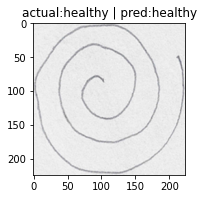

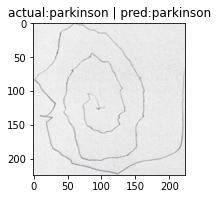

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
num2label={0:'healthy', 1:'parkinson'}
print("custom **model.plan** inference using triton server \n")
plt.subplot(1,2,1)
plt.imshow(Xtest[rn])
plt.title("actual:{} | pred:{}".format(num2label[Ytest[rn]],pred))
plt.show()
plt.subplot(1,2,2)
plt.imshow(Xtest[rn2])
plt.title("actual:{} | pred:{}".format(num2label[Ytest[rn2]],pred2))
plt.show()

## ------------------ using model.onnx for inference as well with Triton  ---------------------

In [21]:
os.makedirs('./model_repository/custom_onnx/1/', exist_ok=True)

## write the corresponding config.pbtxt 

In [33]:
%%writefile ./model_repository/custom_onnx/config.pbtxt
name: "custom_onnx"
platform: "onnxruntime_onnx"
max_batch_size : 1
input [
  {
    name: "hand_drawing:0"
    data_type: TYPE_FP32
    format: FORMAT_NHWC
    dims: [ 224, 224,3 ]
    
  }
]
output [
  {
    name: "Identity:0"
    data_type: TYPE_FP32
    dims: [ 1 ]
    
    label_filename: "labels.txt"
  }
]
instance_group [
  {
    count: 2
    kind: KIND_GPU
  }
]
dynamic_batching {
  preferred_batch_size: [ 1 ]
}

Overwriting ./empty_dir/custom_onnx/config.pbtxt


## write labels.txt file

In [23]:
%%writefile ./model_repository/custom_onnx/labels.txt 
healthy
parkinson

Writing ./model_repository/custom_onnx/labels.txt


## copy the model.onnx to corresponding repository

In [24]:
!cp model.onnx ./model_repository/custom_onnx/1/

In [16]:
os.listdir('./model_repository/custom_onnx/1/')

['model.onnx']

## copy entire directory from local model_repository/custom_onnx/ to Triton model serving directory ./empty_dir/custom_onnx/

In [ ]:
!cp -R ./model_repository/custom_onnx/ ./emptcusty_dir/custom_onnx/

## verify that the Triton server loads the custom_onnx model successfully 

In [46]:
%%html
    <tr>
    <td> <img src="./pics/custom_onnx_load_successfully.JPG" alt="image" style="width: 1200px;"/> </td>
    </tr>

""


## use model.onnx to make inference 

In [52]:
model_name = "custom_onnx"
ctx = InferContext(url, protocol, model_name, model_version, verbose=False)
out = triton_inferer(ctx, input_name, output_name, Xtest[rn].reshape(1,224,224,3))
out2 = triton_inferer(ctx, input_name, output_name, Xtest[rn2].reshape(1,224,224,3))
out,out2

([array([0.02071971], dtype=float32)], [array([0.6517854], dtype=float32)])

In [53]:
pred=process_prob2pred(out)
pred2=process_prob2pred(out2)
pred,Ytest[rn], pred2, Ytest[rn2]

model_output 1 [0.02071971]
pred <class 'int'> 0
model_output 1 [0.6517854]
pred <class 'int'> 1


('healthy', 0, 'parkinson', 1)

custom **model.plan** inference using triton server 



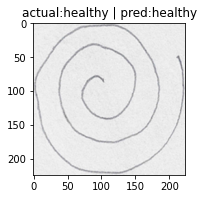

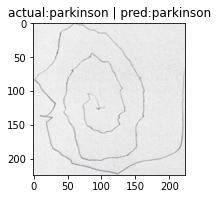

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib inline
num2label={0:'healthy', 1:'parkinson'}
print("custom **model.plan** inference using triton server \n")
plt.subplot(1,2,1)
plt.imshow(Xtest[rn])
plt.title("actual:{} | pred:{}".format(num2label[Ytest[rn]],pred))
plt.show()
plt.subplot(1,2,2)
plt.imshow(Xtest[rn2])
plt.title("actual:{} | pred:{}".format(num2label[Ytest[rn2]],pred2))
plt.show()